# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *Under construction*

In [41]:
import pandas as pd
import numpy as np
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

Suppose we have a matrix of data $X=\{x_t\}_{t=0}^{T-1}$, where $x_t=\{x_{i, t}\}_{i=1}^n$ is a vector of variabels at time $t$.

In [42]:
# Class to be built
class MonteCarlo():
    def __init__(self, df: pd.DataFrame):
        self._df = df

    @property
    def df(self):
        return self._df

    def _find_eig(self):
        array = self.df.to_numpy()

In [43]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'NAS.OL')
df = fetch_data(tickers).dropna()
df

Ticker,DNB.OL,NAS.OL,NHY.OL,YAR.OL
Date,,,,
2004-03-25 00:00:00+01:00,17.060760,1216.948120,10.377869,22.093437
2004-03-26 00:00:00+01:00,17.216927,1199.807983,10.389774,22.526642
2004-03-29 00:00:00+02:00,17.255960,1216.948120,10.330266,21.985130
2004-03-30 00:00:00+02:00,17.177877,1222.661499,10.246957,21.660233
2004-03-31 00:00:00+02:00,17.568291,1199.807983,10.282660,21.573589
...,...,...,...,...
2023-10-18 00:00:00+02:00,223.300003,8.176000,60.500000,387.899994
2023-10-19 00:00:00+02:00,207.600006,8.216000,59.320000,386.000000
2023-10-20 00:00:00+02:00,206.000000,7.920000,58.020000,361.600006


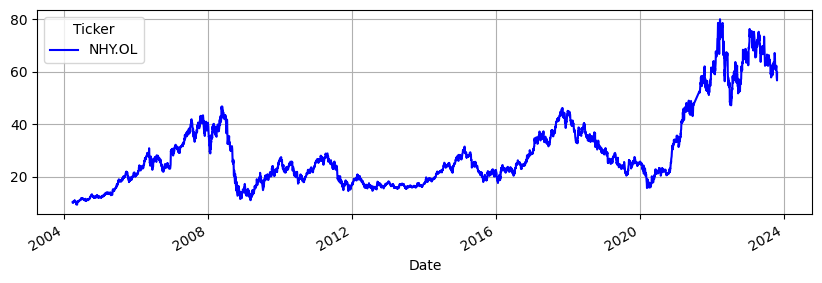

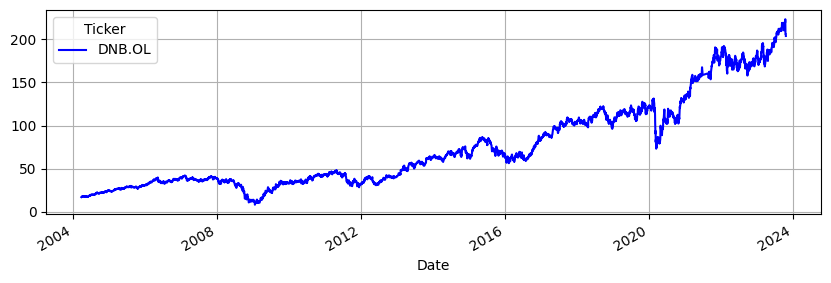

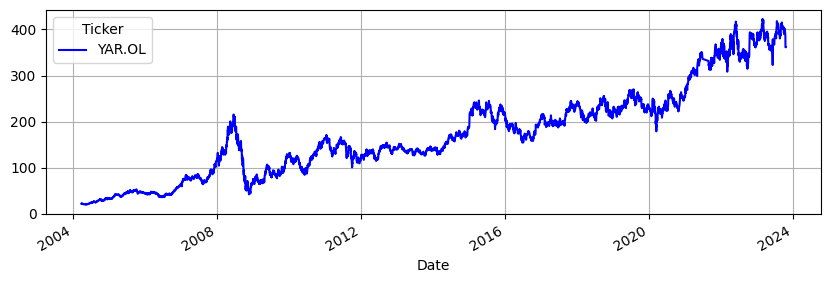

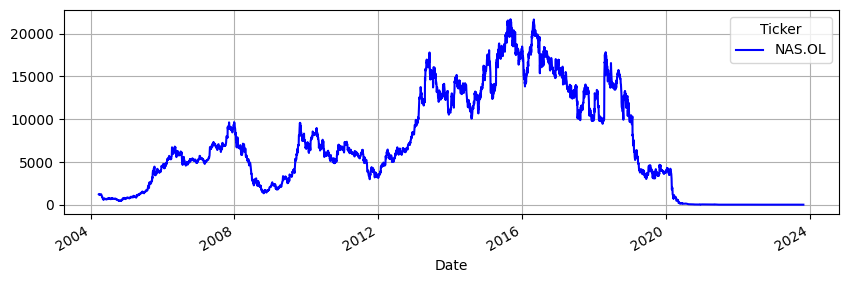

In [44]:
for ticker in tickers:
    df[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [45]:
# Calculating log-differences and removing first value
df_diff = np.log(df).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,NAS.OL,NHY.OL,YAR.OL
Date,,,,
2004-03-26 00:00:00+01:00,0.009112,-0.014185,0.001147,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.014185,-0.005744,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,0.004684,-0.008097,-0.014888
2004-03-31 00:00:00+02:00,0.022473,-0.018869,0.003478,-0.004008
2004-04-01 00:00:00+02:00,-0.011173,-0.014389,-0.005804,0.004008
...,...,...,...,...
2023-10-18 00:00:00+02:00,0.016708,-0.038863,-0.018343,-0.010514
2023-10-19 00:00:00+02:00,-0.072903,0.004880,-0.019697,-0.004910
2023-10-20 00:00:00+02:00,-0.007737,-0.036692,-0.022159,-0.065299


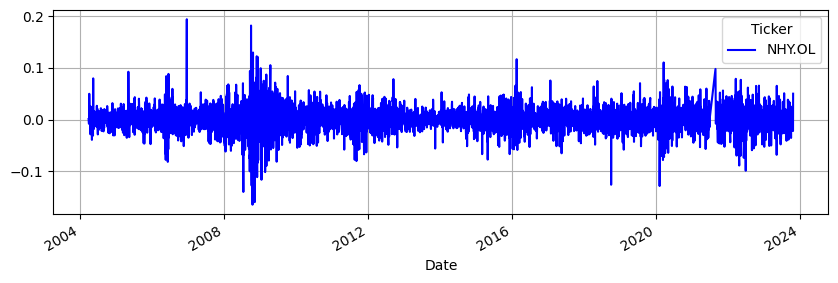

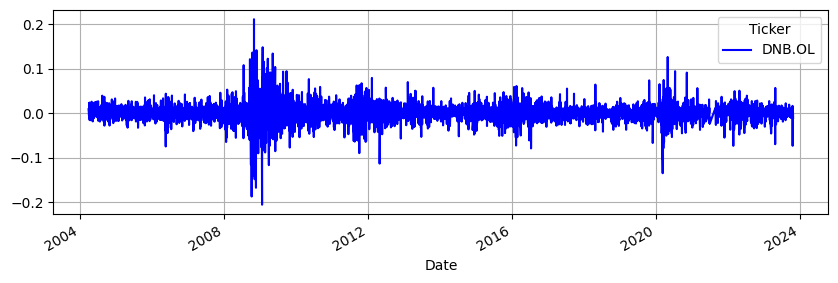

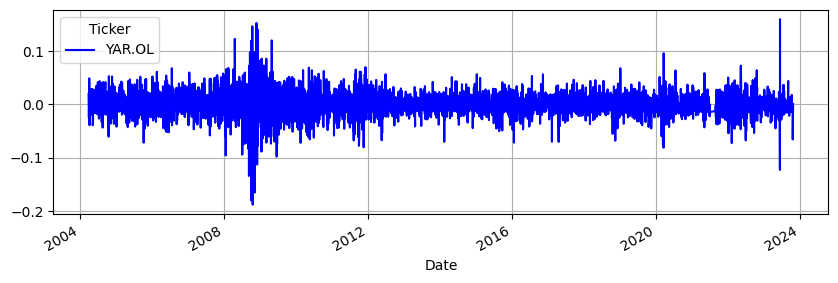

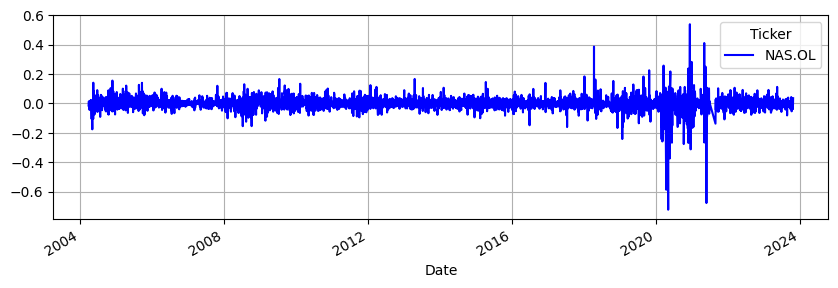

In [46]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [47]:
df_diff.corr()

Ticker,DNB.OL,NAS.OL,NHY.OL,YAR.OL
Ticker,,,,
DNB.OL,1.000000,0.194797,0.482696,0.418200
NAS.OL,0.194797,1.000000,0.204178,0.167189
NHY.OL,0.482696,0.204178,1.000000,0.487625
YAR.OL,0.418200,0.167189,0.487625,1.000000


In [48]:
models = {}
for ticker in tickers:
    models[ticker] = arch_model(df_diff[[ticker]], vol='garch', p=1, o=0, q=1, rescale=False)

In [49]:
fits = {key: val.fit() for key, val in models.items()}

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1755907893.445155
Iteration:      2,   Func. Count:     18,   Neg. LLF: 134548490071160.64
Iteration:      3,   Func. Count:     32,   Neg. LLF: 433549445.3772635
Iteration:      4,   Func. Count:     44,   Neg. LLF: 202910363841801.25
Iteration:      5,   Func. Count:     58,   Neg. LLF: -11868.645846118023
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11868.64587500204
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5963716089.810068
Iteration:      2,   Func. Count:     18,   Neg. LLF: -12972.983240466017
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12972.983253209226
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 97845066.91909456
I

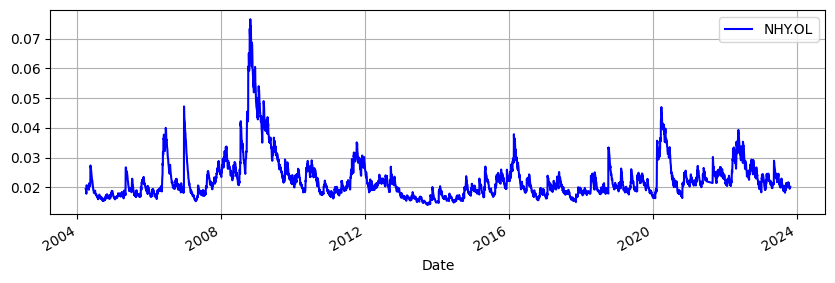

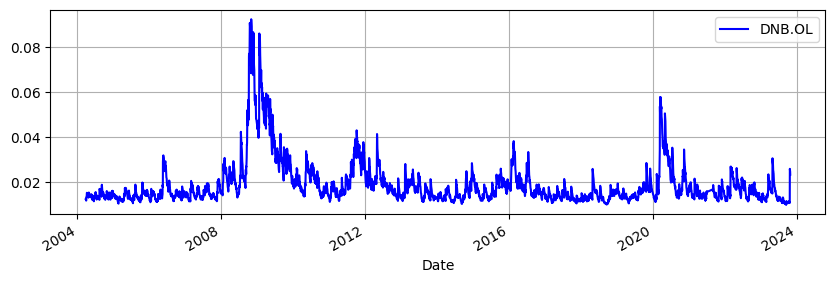

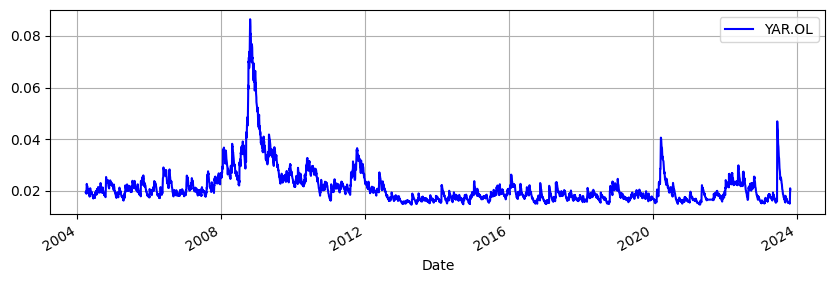

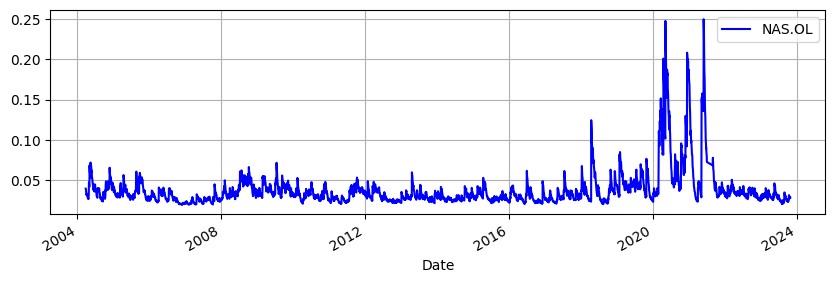

In [50]:
for ticker in tickers:
    pd.DataFrame({ticker: fits[ticker].conditional_volatility}).plot(color='b', figsize=(10, 3), grid=True)